# Áp dụng RNNs cho: Named Entity Recognition

### Dự đoán named entities trong cơ sở dữ liệu GMB(Groningen Meaning Bank) 

Sử dụng Sequence Tagging với mô hình LSTM-CRF để trích xuất tên các thực thể trong văn bản
nhãn các thực thể được mã hóa sử dụng các ký hiệu BIO, trong đó mỗi nhãn thực thể được gán với ký hiệu B hoặc I. B- ký hiệu là bắt đầu (begining) và I- là bên trong (inside) một thực thể. Các ký hiệu này dùng để xác định các thực thể có nhiều từ, ví dụ với câu :"World War II", các nhãn là:(B-eve, I-eve, I-eve). Các từ khác, không thuộc thực thể được gán nhãn là O.
Tag | Label meaning | Example Given
------------ | ------------- | 
geo | Geographical Entity | London
org | Organization | ONU
per | Person | Bush
gpe | Geopolitical Entity | British
tim | Time indicator | Wednesday
art | Artifact | Chrysler
eve | Event | Christmas
nat | Natural Phenomenon | Hurricane
O | No-Label | the

Chúng ta sẽ thực hiện:
- Preprocess text data for NLP
- Build and train a Bi-directional LSTM-CRF model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own sentences!
Mô hình:
<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

In [ ]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Các tham số

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 10  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Câu hỏi 1: Đọc và xử lý dữ liệu

In [ ]:
# data = đọc dữ liệu csv với pandas
# Hiển thị một số mẫu để kiểm tra
### YOUR CODE HERE ###
#Kiểm tra số lượng words
#Kiểm tra số lượng tags
# Show first 5 rows

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['O', 'I-nat', 'I-eve', 'B-nat', 'I-art', 'B-gpe', 'I-org', 'I-gpe', 'B-per', 'I-per', 'B-eve', 'I-tim', 'B-geo', 'I-geo', 'B-org', 'B-art', 'B-tim']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
class SentenceGetter(object):
    # Xây dựng lớp SentenceGetter, có hàm get_next để
    # duyệt và trả về từng câu theo định dạng sau:
    #[(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]
    ### YOUR CODE HERE ###
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

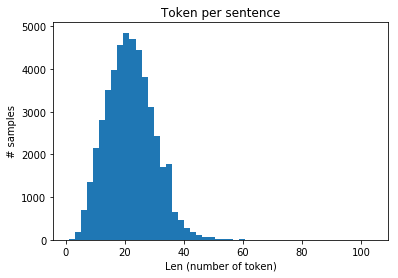

In [ ]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Câu 2: Tiền xử lý dữ liệu

- Sử dụng từ điển `word2idx` để chuyển 1 từ thành 1 số nguyên ID và tương tự từ điển `tag2idx` cho nhãn
- Padding tất cả các câu có cùng số từ `MAX_LEN`

In [ ]:
# Xây dựng từ điển từ vựng Khóa:từ -> Giá trị: số thứ tự của token
# 2 phần tử đầu tiên cho 2 token: PAD và UNK (unknown words)
### YOUR CODE HERE ###

# Từ điển Key:token_index -> Value:word
### YOUR CODE HERE ###

# Từ điển Key:Label/Tag -> Value:tag_index
# Phần tử đầu tiên cho token PAD
### YOUR CODE HERE ###

# Từ điển Key:tag_index -> Value:Label/Tag
### YOUR CODE HERE ###

# Hiển thị để kiểm tra một số phần tử trong các từ điển vừa tạo
### YOUR CODE HERE ###

from keras.preprocessing.sequence import pad_sequences
# Biểu diễn vector cho các câu, mỗi từ --> 1 số nguyên, câu => vector
### YOUR CODE HERE ###

# Padding các câu về cùng chiều dài MAXLEN
### YOUR CODE HERE ###

# tương tự với các nhãn (Tag/Label)
# Chuyển các biểu diễn số (index) cho các tag
y = ### YOUR CODE HERE ###
# Padding các câu về cùng chiều dài
y = ### YOUR CODE HERE ###

from keras.utils import to_categorical
# tạo One-Hot encode cho y
### YOUR CODE HERE ###

from sklearn.model_selection import train_test_split
# tách dữ liệu thành 2 tập train - test theo tỉ lệ nhất 8:2
### YOUR CODE HERE ###

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 9881
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 13
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [16817  7825 10253 17489    66 10783  7144 32555  6507  8582  7721 25544
 28446  2656 25382  8582 32363  7825 23884 21607 15364 29850 18029  8610
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0.

###  Câu 3: Xây dựng mô hình
Xây dựng mô hình như sau:
<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Xây dựng mô hình như hình 7 bồm có các lớp Bi-LSTM và CRF
# Hiển trị kiến trúc mô hình
### YOUR CODE HERE ###

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 738,328
Trainable params: 738,328
Non-trainable params: 0
_________________________________________________________________


####  Câu 4: Huấn luyện và đánh giá mô hình

In [ ]:
# huấn luyện mô hình với các Hyperparams được định nghĩa ở trên, train_size = 0.8
### YOUR CODE HERE ###

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 254s 7ms/step - loss: 9.1008 - acc: 0.9034 - val_loss: 9.0202 - val_acc: 0.9517
Epoch 2/5
38846/38846 [==============================] - 247s 6ms/step - loss: 8.8708 - acc: 0.9589 - val_loss: 8.9733 - val_acc: 0.9625
Epoch 3/5
38846/38846 [==============================] - 246s 6ms/step - loss: 8.8402 - acc: 0.9668 - val_loss: 8.9584 - val_acc: 0.9648
Epoch 4/5
38846/38846 [==============================] - 248s 6ms/step - loss: 8.8287 - acc: 0.9703 - val_loss: 8.9542 - val_acc: 0.9654
Epoch 5/5
38846/38846 [==============================] - 249s 6ms/step - loss: 8.8227 - acc: 0.9721 - val_loss: 8.9500 - val_acc: 0.9681


####  Câu 5: Đánh giá mô hình tên tập test

In [ ]:
# Dự đoán kết quả trên tập test
### YOUR CODE HERE ###

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
# tính các độ đo
### YOUR CODE HERE ###

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00        52
      B-eve       1.00      0.33      0.50        15
      B-geo       0.86      0.90      0.88      3677
      B-gpe       0.97      0.93      0.95      1570
      B-nat       0.00      0.00      0.00        22
      B-org       0.74      0.73      0.74      2012
      B-per       0.82      0.82      0.82      1726
      B-tim       0.93      0.87      0.90      2063
      I-art       0.00      0.00      0.00        36
      I-eve       0.00      0.00      0.00        11
      I-geo       0.83      0.77      0.80       696
      I-gpe       0.92      0.57      0.71        21
      I-nat       0.00      0.00      0.00         8
      I-org       0.74      0.81      0.77      1657
      I-per       0.87      0.90      0.88      1835
      I-tim       0.84      0.73      0.78       642
          O       0.99      0.99      0.99     88839
        PAD       1.00      1.00      1.00   

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


####  Câu 6: Quan sát kết quả dự đoán trên một số mẫu

In [ ]:
# chọn 1 câu ngẫu nhiên
### YOUR CODE HERE ###

# dự đoán kết quả
### YOUR CODE HERE ###

# Hiển thị kết quả
print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 2106 of 4796 (Test Set)
Word           ||True ||Pred
He             : O     O
said           : O     O
,              : O     O
however        : O     O
,              : O     O
the            : O     O
world          : O     O
body           : O     O
remains        : O     O
committed      : O     O
to             : O     O
work           : O     O
for            : O     O
peace          : O     O
in             : O     O
such           : O     O
places         : O     O
as             : O     O
Lebanon        : B-geo B-geo
,              : O     O
Darfur         : B-geo B-geo
,              : O     O
Haiti          : B-geo B-geo
and            : O     O
Iraq           : B-geo B-geo
.              : O     O


# lưu mô hình

In [ ]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Lưu mô hình
model.save_weights('models/lstm_crf_weights.h5')

### Câu 7: Load mô hình và dự đoán kết quả một số câu do người dùng tự gõ vào
Ví dụ:
- Obama was the president of USA.
- The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906
- Next Monday is Christmas!

In [ ]:
# load lại mô hình
### YOUR CODE HERE ###

In [ ]:
# dự đoán kết quả cho 3 câu trên
### YOUR CODE HERE ###